In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]
graph.add_edges(graph.edges()[1], graph.edges()[0])

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_graphsage_linkpred_43_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f9dc46a2e70> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(86855)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

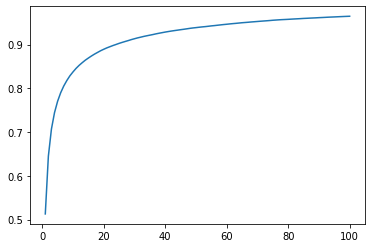

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.5129, 0.6449, 0.7070, 0.7445, 0.7704, 0.7899, 0.8053, 0.8178, 0.8286,
        0.8375, 0.8456, 0.8526, 0.8587, 0.8644, 0.8693, 0.8740, 0.8783, 0.8822,
        0.8860, 0.8894, 0.8925, 0.8952, 0.8979, 0.9003, 0.9029, 0.9051, 0.9072,
        0.9093, 0.9115, 0.9134, 0.9154, 0.9170, 0.9187, 0.9202, 0.9216, 0.9230,
        0.9246, 0.9260, 0.9274, 0.9287, 0.9299, 0.9310, 0.9321, 0.9331, 0.9341,
        0.9351, 0.9361, 0.9372, 0.9381, 0.9389, 0.9397, 0.9405, 0.9412, 0.9420,
        0.9428, 0.9435, 0.9443, 0.9451, 0.9459, 0.9466, 0.9474, 0.9480, 0.9487,
        0.9494, 0.9501, 0.9506, 0.9512, 0.9518, 0.9524, 0.9529, 0.9535, 0.9540,
        0.9545, 0.9551, 0.9557, 0.9562, 0.9567, 0.9571, 0.9575, 0.9578, 0.9583,
        0.9587, 0.9591, 0.9594, 0.9599, 0.9602, 0.9606, 0.9609, 0.9613, 0.9617,
        0.9620, 0.9623, 0.9627, 0.9630, 0.9633, 0.9637, 0.9640, 0.9643, 0.9646,
        0.9649])

In [18]:
percentages.max()

tensor(0.9649)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.68727376, 0.6741377 , 0.66454277, 0.65600881, 0.64921963,
       0.6433304 , 0.63794783, 0.63335287, 0.62921605, 0.62569105,
       0.62242903, 0.61934998, 0.61652068, 0.61383405, 0.61139699,
       0.6091291 , 0.60693455, 0.60489263, 0.60307001, 0.60125514,
       0.59953748, 0.59797759, 0.59640467, 0.59499778, 0.59363021,
       0.59230015, 0.5909912 , 0.58979177, 0.58860175, 0.58748005,
       0.58638042, 0.58531852, 0.58429574, 0.58335015, 0.58239887,
       0.58147812, 0.58054666, 0.57970603, 0.57884536, 0.57800869,
       0.57719957, 0.57640157, 0.57562283, 0.5748858 , 0.57418979,
       0.57344625, 0.5727782 , 0.57213319, 0.57148401, 0.57086281,
       0.57023887, 0.56960793, 0.56900492, 0.5684015 , 0.56780359,
       0.56721375, 0.56663964, 0.56609652, 0.5655636 , 0.56502326,
       0.5645046 , 0.56397742, 0.56350598, 0.56302519, 0.56253039,
       0.56203404, 0.5615577 , 0.56109112, 0.56066433, 0.56019954,
       0.55974877, 0.55930296, 0.55887706, 0.55844543, 0.55800

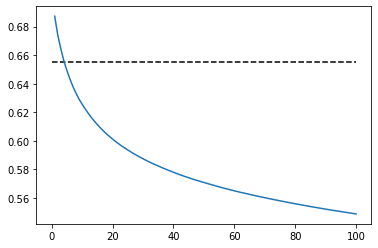

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f9d70613b40> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(90254)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.8975069141500285

In [88]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [89]:
indices

array([[     0,  79872,  10839, ..., 120943, 160051,  17959],
       [     1, 154949, 100594, ..., 102900, 150523,  75802],
       [     2,  65576, 122406, ...,  72588, 103194,  84167],
       ...,
       [169340,  18094, 107677, ...,   4875,  85765, 137236],
       [169341,  34227,  21928, ..., 138717,  54854,  86839],
       [169342, 127946,  17652, ..., 104379,  35377, 103977]])

In [90]:
sum(emb_norm[0] * emb_norm[411])

0.795013828300057

In [91]:
distances

array([[1.        , 0.99369913, 0.99368393, ..., 0.9720304 , 0.9720096 ,
        0.97195655],
       [1.0000001 , 0.96459544, 0.94372463, ..., 0.6072341 , 0.60657007,
        0.60546565],
       [1.0000001 , 0.9869001 , 0.9834507 , ..., 0.93246484, 0.93237966,
        0.9322831 ],
       ...,
       [0.99999994, 0.97016114, 0.9602374 , ..., 0.8809873 , 0.88050306,
        0.87973726],
       [0.9999999 , 0.9836593 , 0.9828771 , ..., 0.9604608 , 0.96030194,
        0.9600512 ],
       [0.9999999 , 0.96554494, 0.9649838 , ..., 0.7464995 , 0.74586844,
        0.7444006 ]], dtype=float32)

In [92]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [93]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

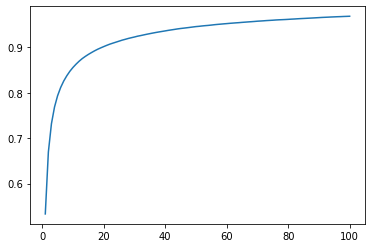

In [94]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [95]:
percentages

tensor([0.5330, 0.6694, 0.7318, 0.7686, 0.7934, 0.8117, 0.8260, 0.8375, 0.8474,
        0.8558, 0.8630, 0.8695, 0.8752, 0.8801, 0.8845, 0.8885, 0.8923, 0.8958,
        0.8988, 0.9017, 0.9045, 0.9072, 0.9094, 0.9116, 0.9138, 0.9160, 0.9178,
        0.9197, 0.9214, 0.9229, 0.9247, 0.9260, 0.9275, 0.9290, 0.9303, 0.9316,
        0.9329, 0.9341, 0.9352, 0.9364, 0.9375, 0.9386, 0.9396, 0.9407, 0.9416,
        0.9424, 0.9432, 0.9441, 0.9450, 0.9458, 0.9465, 0.9472, 0.9479, 0.9485,
        0.9492, 0.9500, 0.9507, 0.9513, 0.9519, 0.9524, 0.9530, 0.9536, 0.9541,
        0.9545, 0.9552, 0.9556, 0.9562, 0.9566, 0.9572, 0.9577, 0.9581, 0.9586,
        0.9591, 0.9595, 0.9599, 0.9604, 0.9608, 0.9611, 0.9614, 0.9618, 0.9622,
        0.9626, 0.9630, 0.9634, 0.9638, 0.9641, 0.9645, 0.9648, 0.9652, 0.9656,
        0.9660, 0.9664, 0.9667, 0.9670, 0.9673, 0.9676, 0.9678, 0.9681, 0.9684,
        0.9687])

### Percentage of same class neighbors by neighborhood size

In [96]:
ind_labels = label_transform(indices)

In [97]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [98]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [99]:
perc_same_class = n_same_class / n_total

In [100]:
perc_same_class

array([0.68576794, 0.67189373, 0.66238542, 0.6537678 , 0.6465871 ,
       0.64043588, 0.63543054, 0.63083727, 0.62668798, 0.62296522,
       0.61943189, 0.61633883, 0.61345862, 0.61076674, 0.60835897,
       0.6059798 , 0.60382148, 0.60175403, 0.59975347, 0.59790839,
       0.59620415, 0.59457567, 0.59306029, 0.59155949, 0.59013198,
       0.58881587, 0.58750496, 0.58631193, 0.58515964, 0.58400761,
       0.58289427, 0.58182745, 0.58073671, 0.57974192, 0.57873327,
       0.57776902, 0.57687556, 0.5759421 , 0.57505727, 0.57421299,
       0.57339045, 0.5725992 , 0.57181427, 0.57109549, 0.57034264,
       0.56963369, 0.56889461, 0.56819665, 0.56751284, 0.56687398,
       0.5662193 , 0.56559786, 0.56498294, 0.56435099, 0.56373589,
       0.56314931, 0.56256134, 0.56198244, 0.5614487 , 0.56089662,
       0.56036158, 0.55983637, 0.55933074, 0.55881425, 0.55827876,
       0.55776988, 0.55729513, 0.55681794, 0.55634867, 0.55587476,
       0.55542169, 0.5549748 , 0.55452179, 0.55406658, 0.55363

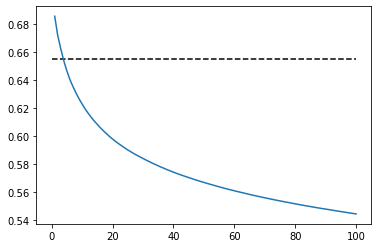

In [101]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

### Percentage of same class neighbors by angular section

In [102]:
distance_list = np.linspace(0.99, 0.5, 50)
distance_list

array([0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9 , 0.89,
       0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 , 0.79, 0.78,
       0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69, 0.68, 0.67,
       0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58, 0.57, 0.56,
       0.55, 0.54, 0.53, 0.52, 0.51, 0.5 ])

In [103]:
perc_section_same_class = np.zeros(distance_list.shape)
n_section_neighbors = np.zeros(distance_list.shape)
n_section_same_class = np.zeros(distance_list.shape)
for idx, dist in enumerate(distance_list):
    n_section_neighbors[idx] = (distances > dist)[:, 1:].sum()
    n_section_same_class[idx] = (is_same_class * (distances > dist)[:, 1:]).sum()
    perc_section_same_class[idx] = n_section_same_class[idx] / n_section_neighbors[idx]
perc_section_same_class

array([0.70702372, 0.76126836, 0.76550971, 0.76321472, 0.75824694,
       0.75146291, 0.74429125, 0.73704422, 0.72995534, 0.72283831,
       0.71577092, 0.70895823, 0.70228809, 0.69601389, 0.69000174,
       0.68424388, 0.67869413, 0.67325655, 0.66796984, 0.6629379 ,
       0.658139  , 0.65351391, 0.64906984, 0.64471626, 0.64050876,
       0.63649447, 0.6324914 , 0.62852602, 0.62458054, 0.62058234,
       0.61649665, 0.61230107, 0.60798762, 0.60339733, 0.59852353,
       0.59329435, 0.58772211, 0.58176119, 0.57547259, 0.56896286,
       0.56254553, 0.55663307, 0.55176065, 0.54819982, 0.54604646,
       0.54497534, 0.54452944, 0.54437945, 0.54434254, 0.54433186])

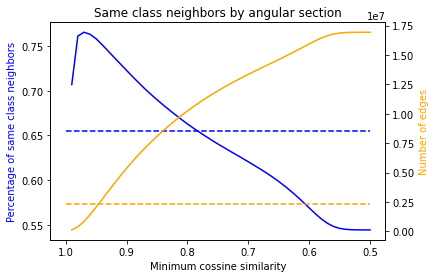

In [104]:
fig, ax1 = plt.subplots()
ax1.set_title('Same class neighbors by angular section')
ax1.set_ylabel('Percentage of same class neighbors', color='blue')
ax1.set_xlabel('Minimum cossine similarity')
ax1.invert_xaxis()
ax1.plot(distance_list, perc_section_same_class, color='blue')
ax1.hlines(0.6551, 1, 0.5, color='blue', ls='--')

ax2 = ax1.twinx()
ax2.set_ylabel('Number of edges', color='orange')
ax2.plot(distance_list, n_section_neighbors, color='orange')
ax2.hlines(graph.edges()[0].shape[0], 1, 0.5, color='orange', ls='--')

#### Evaluating a single threshold

In [105]:
thresh = 0.9

Number of isolated nodes

In [106]:
(((distances > thresh)[:, 1:] * 1)[:,0] == 0).sum()

24230

Number of connected nodes

In [107]:
(((distances > thresh)[:, 1:] * 1)[:,0] == 1).sum()

145113

Degree distribution

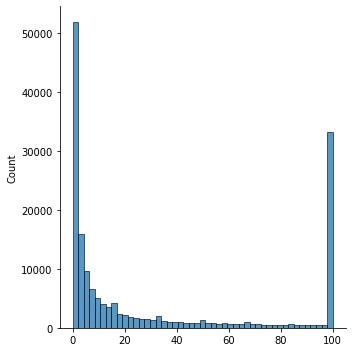

In [108]:
degree_dist = ((distances > thresh)[:, 1:] * 1).sum(axis=1)
sns.displot(degree_dist)

## Inner Product

In [58]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [59]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [60]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f9d7047a7e0> >

In [61]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [62]:
distances, indices = index_ip.search(embeddings, 2)

In [63]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(8705)

In [64]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [65]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

3.2742036517852284

In [66]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [67]:
indices

array([[  8856, 113109,  29771, ..., 117698,  63466,  19066],
       [100594,      1, 154949, ..., 110642,  15419,  42461],
       [148636, 149945,  48863, ..., 154703, 145759,  27859],
       ...,
       [ 14350, 111649, 135327, ..., 168389, 102517, 117340],
       [  8856, 113109,  29771, ..., 105730, 114925, 162151],
       [ 62601,  63289, 141488, ...,  40983,  35377, 166861]])

In [68]:
sum(embeddings[0] * embeddings[411])

5.548407303570457

In [69]:
distances

array([[10.675673 , 10.424516 , 10.384962 , ...,  7.317318 ,  7.3148932,
         7.3141165],
       [20.315107 , 17.02031  , 16.054043 , ..., 10.19313  , 10.19125  ,
        10.181026 ],
       [15.884782 , 15.544336 , 15.4241705, ..., 12.0462265, 12.041972 ,
        12.032824 ],
       ...,
       [ 8.979736 ,  8.857303 ,  8.6575165, ...,  7.482936 ,  7.4754558,
         7.4751062],
       [10.813337 , 10.494616 , 10.454643 , ...,  8.278847 ,  8.27759  ,
         8.267199 ],
       [26.860435 , 26.814445 , 26.759996 , ..., 14.551954 , 14.477032 ,
        14.346691 ]], dtype=float32)

In [70]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [71]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

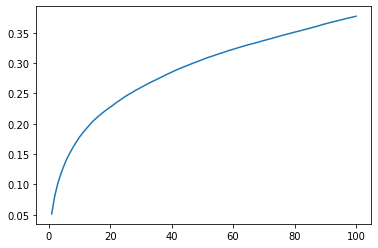

In [72]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [73]:
percentages

tensor([0.0514, 0.0810, 0.1017, 0.1176, 0.1310, 0.1429, 0.1526, 0.1616, 0.1698,
        0.1776, 0.1842, 0.1903, 0.1962, 0.2018, 0.2069, 0.2114, 0.2157, 0.2198,
        0.2236, 0.2273, 0.2308, 0.2348, 0.2382, 0.2417, 0.2451, 0.2483, 0.2511,
        0.2542, 0.2570, 0.2597, 0.2623, 0.2652, 0.2679, 0.2702, 0.2727, 0.2750,
        0.2777, 0.2803, 0.2826, 0.2849, 0.2874, 0.2896, 0.2917, 0.2938, 0.2958,
        0.2978, 0.2998, 0.3017, 0.3036, 0.3057, 0.3076, 0.3095, 0.3110, 0.3128,
        0.3145, 0.3162, 0.3179, 0.3196, 0.3212, 0.3227, 0.3243, 0.3258, 0.3273,
        0.3288, 0.3303, 0.3315, 0.3329, 0.3343, 0.3357, 0.3372, 0.3385, 0.3398,
        0.3413, 0.3427, 0.3441, 0.3456, 0.3469, 0.3482, 0.3496, 0.3510, 0.3522,
        0.3535, 0.3548, 0.3562, 0.3575, 0.3589, 0.3602, 0.3617, 0.3633, 0.3647,
        0.3660, 0.3673, 0.3686, 0.3698, 0.3711, 0.3723, 0.3736, 0.3748, 0.3760,
        0.3772])

### Percentage of same class neighbors by neighborhood size

In [74]:
ind_labels = label_transform(indices)

In [75]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [76]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [77]:
perc_same_class = n_same_class / n_total

In [78]:
perc_same_class

array([0.49947149, 0.48995235, 0.48180911, 0.47512888, 0.46992672,
       0.46621256, 0.46305765, 0.46004042, 0.45749554, 0.45535511,
       0.45365646, 0.45180689, 0.45017009, 0.44873085, 0.44725872,
       0.44589384, 0.44458185, 0.44346058, 0.44226433, 0.44118003,
       0.44023387, 0.43943653, 0.43866873, 0.43787904, 0.43710103,
       0.43641671, 0.43575903, 0.43518269, 0.43455753, 0.43393251,
       0.43337982, 0.43283214, 0.43230907, 0.43178672, 0.43132813,
       0.43083597, 0.43035636, 0.42989081, 0.4294502 , 0.42901168,
       0.42859139, 0.42816777, 0.42777168, 0.42738058, 0.42694387,
       0.42653744, 0.42613361, 0.42574907, 0.42536154, 0.42502058,
       0.4246887 , 0.42435596, 0.42401773, 0.42368065, 0.42338696,
       0.42305062, 0.42272929, 0.4224115 , 0.42212311, 0.42184147,
       0.42158001, 0.42129831, 0.42103708, 0.42077387, 0.42049604,
       0.42025715, 0.42001807, 0.41976248, 0.41951628, 0.41930039,
       0.41906047, 0.41880409, 0.4185659 , 0.418313  , 0.41807

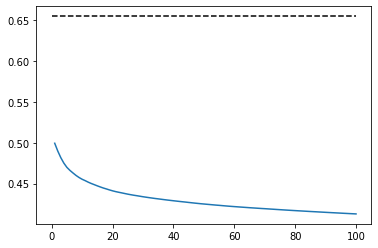

In [79]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [80]:
pca = PCA(n_components=2)

In [81]:
pca.fit(embeddings)

PCA(n_components=2)

In [82]:
emb_2d = pca.transform(embeddings)

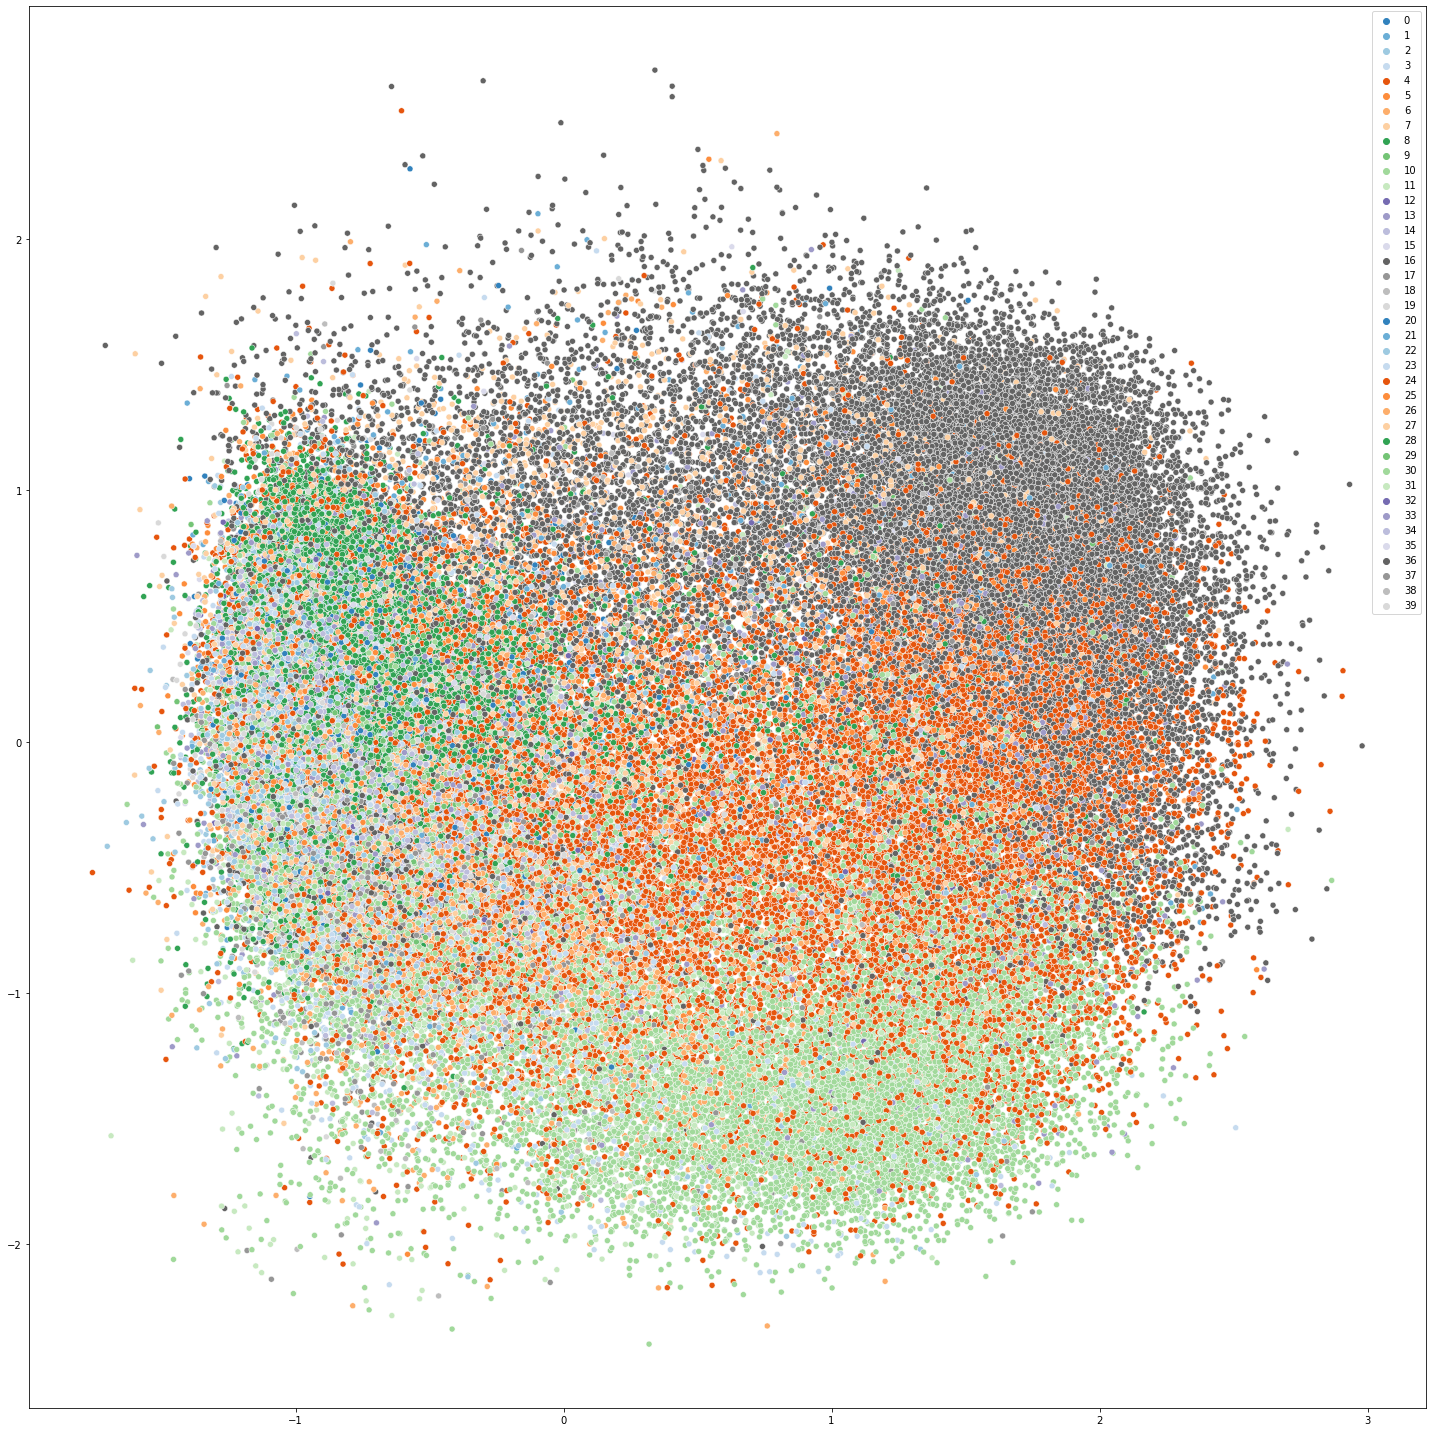

In [83]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [84]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

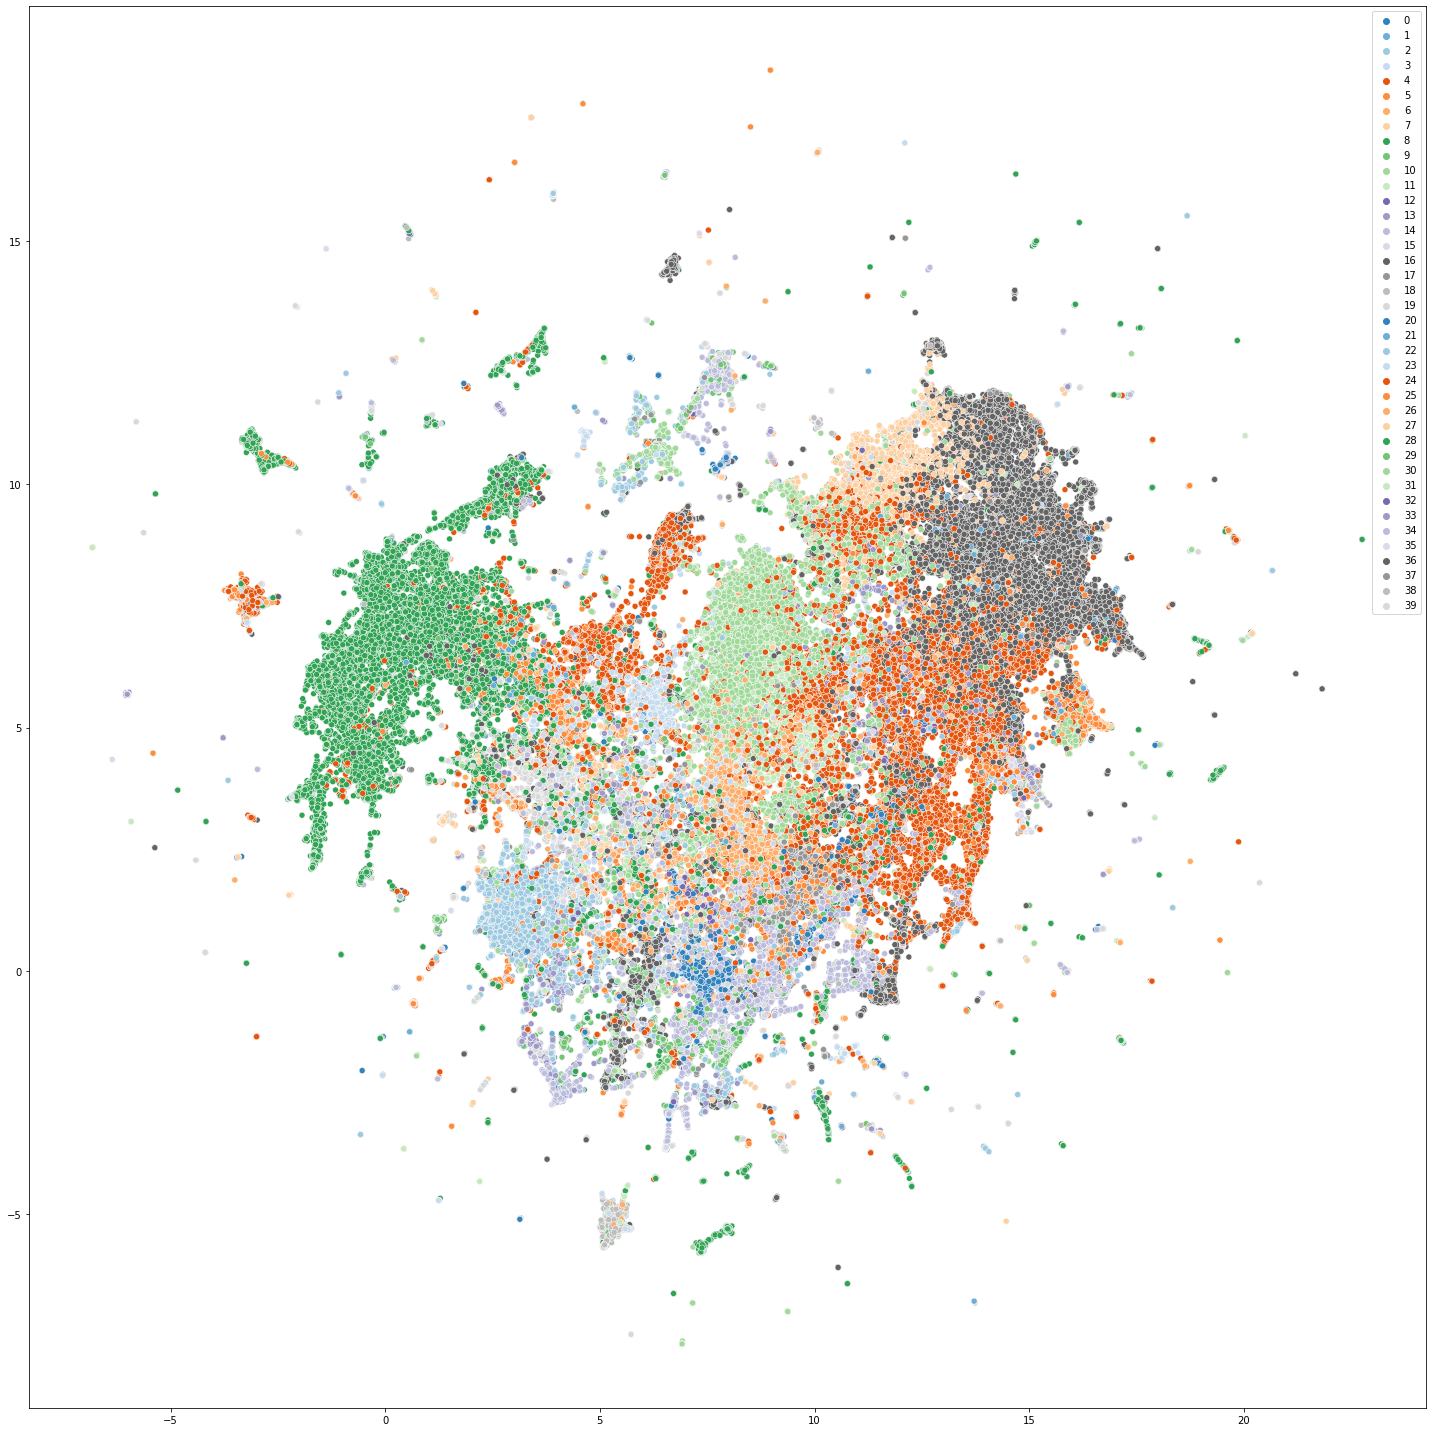

In [85]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [86]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

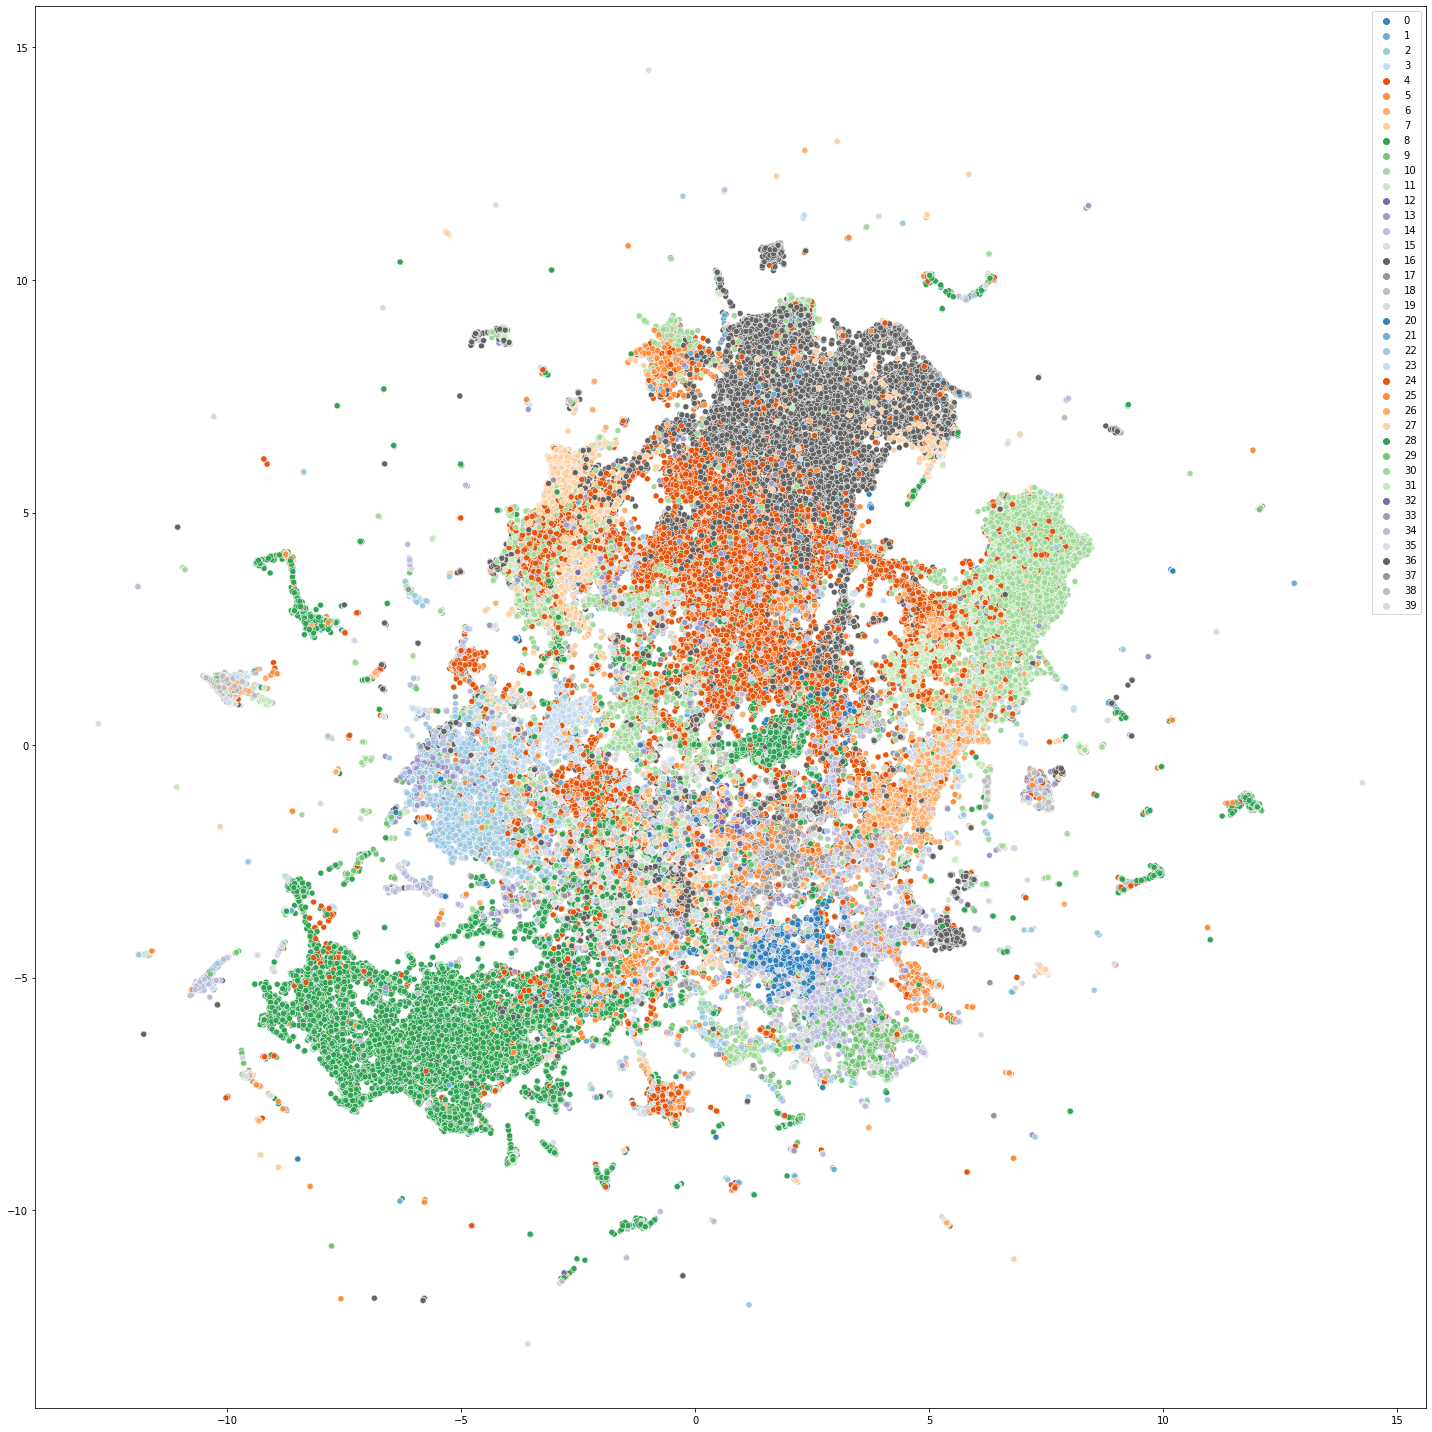

In [87]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()